In [1]:
# Required Packages
import pandas as pd
import numpy as np
import math
import json

# Display
from IPython.core.display import Image, display
import progressbar

# Plots

import seaborn as sns
import matplotlib.pyplot as plt

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

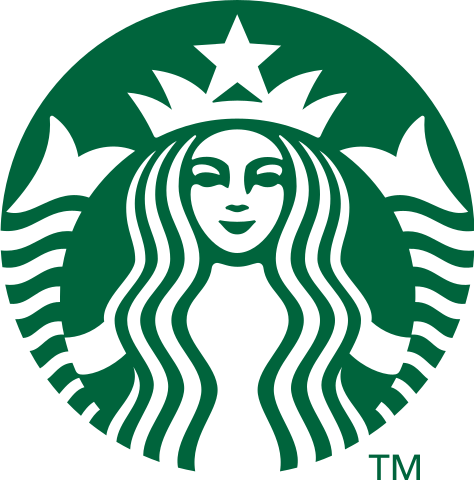

In [2]:
display(Image('https://upload.wikimedia.org/wikipedia/en/thumb/d/d3/Starbucks_Corporation_Logo_2011.svg/474px-Starbucks_Corporation_Logo_2011.svg.png',
              width=300, unconfined=True))

# Starbucks Offer Personalizations

In this article, simulated data that mimics customer behavior on the Starbucks rewards mobile app is used. Starbucks tends to send out offers to users of the mobile app once every few days. These offers are exclusive, that is not all users receive the same offer. An offer can contain a  discount for their products or sometimes BOGO (buy one get one free). These offers have a validity period before the offer expires. The article here is inspired by a [towardsdatascience.com](https://towardsdatascience.com/using-starbucks-app-user-data-to-predict-effective-offers-20b799f3a6d5) article.

### Table of contents
* [Data](#Data)
* [Preprocessing](#Preprocessing)
    * [Portfolio Data](#Portfolio-Data)
    * [Profile Data](#Portfolio-Data)
    * [Transcript Data](#Transcript-Data)
    * [Transcript-Portfolio Data](#Transcript-Portfolio-Data)
* [Analysis](#Analysis)
    * [Analyzing Portfolio Data](#Analyzing-Portfolio-Data)
        * [Channel Distribution for Various Offers](#Channel-Distribution-for-Various-Offers)
        * [Age Distribution Plot](#Age-Distribution-Plot)
        * [Income Distribution Plot](#Income-Distribution-Plot)
        * [Gender Distribution Plot](#Gender-Distribution-Plot)
        * [Membership Plots](#Gender-Distribution-Plot)
* [Analyzing Transcript Data](#Analyzing-Transcript-Data)
    * [Event Plots](#Event-Plots)
    * [Received Reward Plot](#Received-Reward-Plot)
    * [A Customer's Journey](#A-Customer's-Journey)

## Data

The data is contained in three files:

In [3]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

In [4]:
def column_rename(Data):
    Temp = Data.columns.tolist()
    Temp = [x.title() for x in Temp]
    Temp = [x.replace('Id','ID') for x in Temp]
    Data.columns = Temp
    del Temp
    return Data

In [5]:
portfolio = column_rename(portfolio)
portfolio.head().style.hide_index()

Here

| Parameter | Description |
|----------------------------|------------------------------------------------------|
| Reward (int) | Given Reward for Completing an Offer |
| Channels (list of strings) | Email, Mobile App, Social Media, etc |
| Difficulty (int) | Minimum Spending Requirement for Completing an Offer |
| Duration (int) | Time That an Offer is Valid |
| Offer_Type (string) | Type of Offer |
| ID| (string) 	  | Offer ID |

In [6]:
profile = column_rename(profile)
profile.head().style.hide_index()

In the above table:

| Parameter | Description |
|------------------------|--------------------|
| Gender (str) | Customers Gender |
| Age (int) | Customers Age |
| ID (str) | Customers ID |
| Became_Member_On (int) | Date of Membership |
| Income (float) | Customer's Income |

In [7]:
transcript = column_rename(transcript)
transcript.head().style.hide_index()

In the above table:

| Parameter | Description |
|---------------------------|--------------------------------------------------|
| Person (str) | customer ID |
| Event (str) | Record Description |
| time (int) | time in hours (since the beginning of the study) |
| Value - (dict of strings) | offer id or transaction amount |

## Preprocessing

### Portfolio Data

The first thing that needs to be done is converting the categorical variables (that are important for our analysis) into dummy variables. We have,

In [8]:
Temp= portfolio['Channels'].str.join(',').str.get_dummies(',')
portfolio = pd.concat([portfolio, Temp], axis = 1)
del Temp
portfolio.drop(['Channels'], axis = 1, inplace = True)
#renaming column "ID" to "Offer ID"
portfolio.rename(columns={'ID':'offer_ID'},inplace=True)

Therefore, Portfolio Data becomes:

In [9]:
portfolio = column_rename(portfolio)
portfolio.head().style.hide_index()

In [10]:
export_csv = portfolio.to_csv (r'Data\Clean_portfolio.csv', index = None, header=True)

### Profile Data

Searching the **Null** values in the data:

In [11]:
def NN_Table(Inp):
    Out = pd.DataFrame(Inp.isnull().sum(), columns={'Nuumber of NaN'})
    return Out

In [12]:
NN_Table(profile)

Nuumber of NaN
Gender                      2175
Age                            0
ID                             0
Became_Member_On               0
Income                      2175

2175 out of 17000 customers don't have information on gender and income!

Since ages over 100 might be the result of misentering data from users, we can search for ages over 100 and impute them with median ages.

In [13]:
profile.Age[profile.Age>=100].value_counts()

118    2175
100      12
101       5
Name: Age, dtype: int64

In [14]:
# setting Age>=0 to NaN
profile.Age[profile.Age>=100] = np.nan
# imputing missing Ages
median_Age = profile.Age.median()
profile['Age'] = profile.Age.fillna(median_Age)
# converting 'Became_Member_On' column to a columns with date entries
profile['Became_Member_On'] = pd.to_datetime(profile['Became_Member_On'], format='%Y%m%d')
# keeping only the year from 'Became_Member_On' column as 'Member_Since_Year'
profile['Member_Since_Year'] = profile['Became_Member_On'].dt.year

Note that

In [15]:
profile.sort_values(by='Became_Member_On', ascending=True).tail()

Gender   Age                                ID Became_Member_On  \
8079       M  82.0  039e0c539c2f4fc582423412a8bceb40       2018-07-26   
12326      F  59.0  3b9ec536e4224688950913b9cf53362c       2018-07-26   
10282      M  46.0  e4989ca3d8974e28a3fe87aa0b0ce327       2018-07-26   
12902      M  85.0  f1f01be4e2344bf08b7f488c115ad374       2018-07-26   
4357       M  76.0  6597e5ab63754726b83ba2032f008d26       2018-07-26   

        Income  Member_Since_Year  
8079   32000.0               2018  
12326  88000.0               2018  
10282  74000.0               2018  
12902  45000.0               2018  
4357   92000.0               2018

Assuming the data is a snapshot of **the end of 2018**. get member tenure by **the number of months**.

$$Member~Tenure~=(the~end~of~2018)~-~(Became~Member~On)\qquad (In~Months)$$

In [16]:
Temp = pd.to_datetime('20181231', format='%Y%m%d')
profile['Member_Tenure'] = round((Temp - profile['Became_Member_On'])/np.timedelta64(1, 'M'))
del Temp

Thus, the profile data becomes:

In [17]:
profile.head().style.hide_index()

In [18]:
export_csv = profile.to_csv (r'Data\Clean_profile.csv', index = None, header=True)

### Transcript Data

Looking at the value column from the Transcript Data, we notice that, this data needs to be processed to be used for our analysis. Thus, we are searching for different key-value pairs. That can be done using

In [19]:
# Starting with an empty 'value_key'
value_keys = []

Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval=transcript.shape[0],
                                       widgets=[progressbar.Bar('#', '|', '|'), progressbar.Percentage()])
# The Loop
Progress_Bar.start()
for i in range(transcript.shape[0]):
    Counter+=1
    # only reading 'keys' from the dictionary of 'Value'
    # if it is not already in the value_keys list, we can append it
    if transcript.Value[i].keys() not in value_keys:
        value_keys.append(transcript.Value[i].keys())

Progress_Bar.finish()
value_keys

|#########################################################################|100%


[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

Now, we divide **offer id** into individual columns

In [20]:
transcript = pd.concat([transcript, transcript['Value'].apply(pd.Series)], axis=1)

Let's look at the resulting DataFrame.

In [21]:
transcript.head().style.hide_index()

Note that **offer_id** appears in two separate columns since there are two different key types for **offer_id**. We would like to  create a new column to combine the two **offer_id** columns.

In [22]:
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
                                    transcript['offer_id'],transcript['offer id'])
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [23]:
transcript = column_rename(transcript)
transcript.head().style.hide_index()

In [24]:
export_csv = transcript.to_csv (r'Data\Clean_transcript.csv', index = None, header=True)

### Transcript-Portfolio Data

Merging transcript with portfolio to get offer type.

In [25]:
transcript_portfolio = transcript.merge(portfolio,how='left',on='Offer_ID')
transcript_portfolio.head()

Person           Event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              Value  Time  Amount  Reward_x  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0     NaN       NaN   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0     NaN       NaN   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0     NaN       NaN   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0     NaN       NaN   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0     NaN       NaN   

                           Offer_ID  Reward_y  Difficulty  Duration  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9       5.0         5.0       7.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7       5.0        20.0      10.0   
2  2906b810c7d4411798c6938adc9daaa5       2.0        10.0       7.0   
3  fafdcd668e3743c1bb461111dcafc2a4       2.0        10.0      10.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0      10.0        10.0       5.0   

  Offer_Type  Email  Mobile  Social  Web  
0       bogo    1.0     1.0     0.0  1.0  
1   discount    1.0     0.0     0.0  1.0  
2   discount    1.0     1.0     0.0  1.0  
3   discount    1.0     1.0     1.0  1.0  
4       bogo    1.0     1.0     1.0  1.0

However, this creates some undesired columns that we need to modify

In [26]:
# Getting rid of value column
transcript_portfolio.drop('Value', axis=1, inplace=True)
# renaming reward_x and reward_y to reward_received and reward_defined, respectively.
transcript_portfolio.rename(columns={'Reward_x':'Reward_Received', 'Reward_y':'Reward_Defined'},inplace=True)
# Thus
transcript_portfolio.head()

Person           Event  Time  Amount  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0     NaN   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0     NaN   
2  e2127556f4f64592b11af22de27a7932  offer received     0     NaN   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0     NaN   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0     NaN   

   Reward_Received                          Offer_ID  Reward_Defined  \
0              NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9             5.0   
1              NaN  0b1e1539f2cc45b7b9fa7c272da2e1d7             5.0   
2              NaN  2906b810c7d4411798c6938adc9daaa5             2.0   
3              NaN  fafdcd668e3743c1bb461111dcafc2a4             2.0   
4              NaN  4d5c57ea9a6940dd891ad53e9dbe8da0            10.0   

   Difficulty  Duration Offer_Type  Email  Mobile  Social  Web  
0         5.0       7.0       bogo    1.0     1.0     0.0  1.0  
1        20.0      10.0   discount    1.0     0.0     0.0  1.0  
2        10.0       7.0   discount    1.0     1.0     0.0  1.0  
3        10.0      10.0   discount    1.0     1.0     1.0  1.0  
4        10.0       5.0       bogo    1.0     1.0     1.0  1.0

In [27]:
export_csv = transcript_portfolio.to_csv (r'Data\Clean_transcript_portfolio.csv', index = None, header=True)

## Analysis

In this section, a variety of plots are provided to a better understanding of the relationships between parameters.

### Analyzing Portfolio Data
#### Channel Distribution for Various Offers

In [28]:
Offer_Type_List = ['Email','Mobile','Social','Web']
Temp = portfolio.groupby('Offer_Type')[Offer_Type_List].sum()
Temp

Email  Mobile  Social  Web
Offer_Type                               
bogo               4       4       3    3
discount           4       3       2    4
informational      2       2       1    1

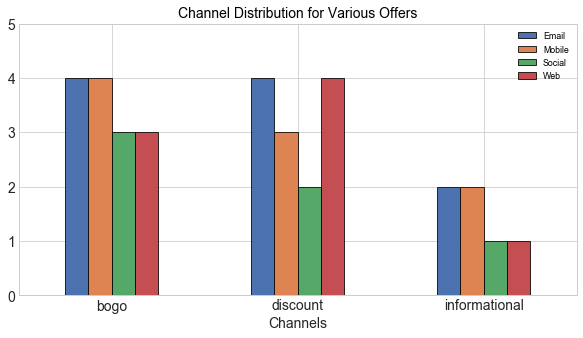

In [29]:
ax = Temp.plot.bar(figsize=(10,5), color= sns.color_palette("deep", 4), edgecolor='k', rot= 0, fontsize = 14)
_ = ax.set_xlabel('Channels')
_ = ax.set_ylim([0, 5])
_ = ax.set_title('Channel Distribution for Various Offers')

It seems that social media is the least efficient channel among all.

#### Age Distribution Plot

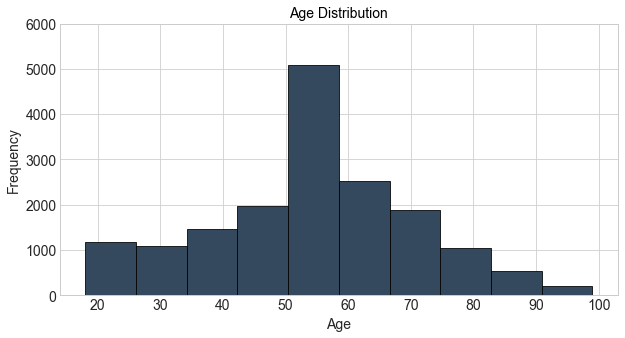

In [30]:
ax =profile.Age.plot.hist(figsize=(10,5), color='#34495e', edgecolor='k', fontsize = 14)
_ = ax.set_title('Age Distribution', fontsize = 14)
_ = ax.set_xlabel('Age')
_ = ax.set_ylim([0, 6e3])

Apparently, costumers are mainly from ages 50 to 60.

#### Income Distribution Plot

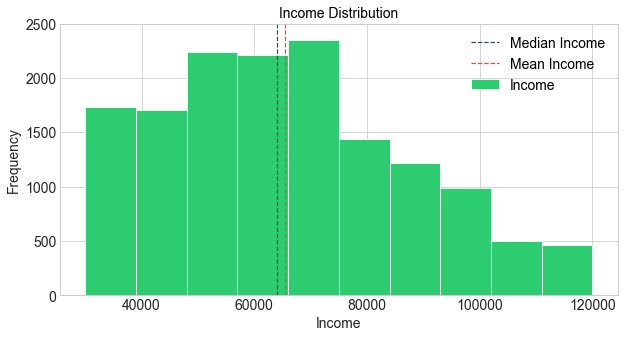

In [31]:
ax = profile.Income.plot.hist(figsize=(10,5), color= '#2ecc71', fontsize = 14)
_ = ax.axvline(profile['Income'].median(), color = '#34495e', linestyle = '--', label = 'Median Income')
_ = ax.axvline(profile['Income'].mean(), color = '#e74c3c', linestyle = '--', label = 'Mean Income')
_ = ax.set_title('Income Distribution', fontsize = 14)
_ = ax.set_xlabel('Income', fontsize = 14)
_ = ax.legend(loc='upper right', fontsize = 14)
_ = ax.set_ylim([0, 2500])

Most of customers income is around 60K.

#### Gender Distribution Plot

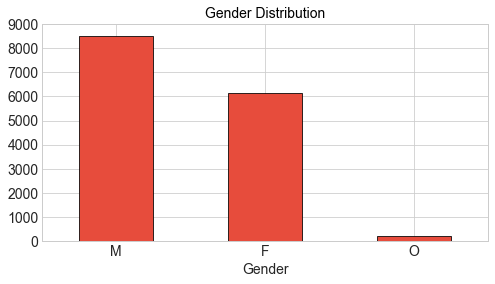

In [32]:
ax= profile.Gender.value_counts().plot.bar(figsize=(8,4), color='#e74c3c', edgecolor='k',fontsize = 14,rot=0)
_ = ax.set_title('Gender Distribution', fontsize = 14)
_ = ax.set_xlabel('Gender', fontsize = 14)
_ = ax.set_ylim([0, 9e3])

More male customers than female customers.

#### Membership Plots

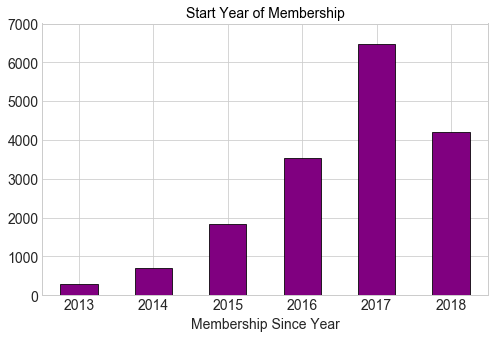

In [33]:
ax=profile['Member_Since_Year'].value_counts().sort_index().plot.bar(figsize=(8,5),
                                                                     color= 'Purple', edgecolor='k', fontsize = 14,rot=0)
_ = ax.set_title('Start Year of Membership', fontsize = 14)
_ = ax.set_xlabel('Membership Since Year', fontsize = 14)
_ = ax.set_ylim([0, 7e3])

In [34]:
Temp = profile.groupby('Member_Since_Year')['Gender'].value_counts().unstack().sort_index()
Temp

Gender                F     M   O
Member_Since_Year                
2013                 74   197   3
2014                138   520   4
2015                663   905  29
2016               1509  1483  32
2017               2443  3067  89
2018               1302  2312  55

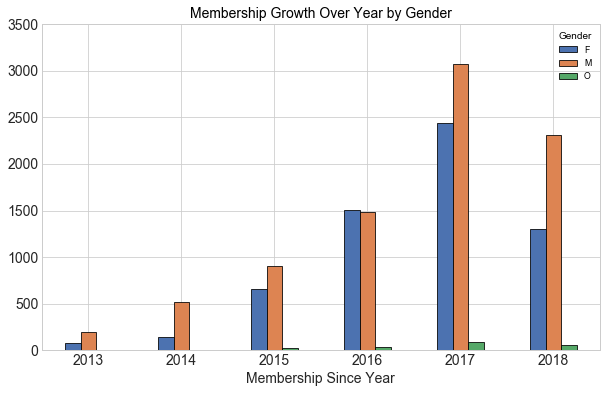

In [35]:
ax=Temp.sort_index().plot.bar(figsize=(10,6), color= sns.color_palette("deep", 3), edgecolor='k', rot=0, fontsize = 14)
_ = ax.set_title('Membership Growth Over Year by Gender', fontsize = 14)
_ = ax.set_xlabel('Membership Since Year', fontsize = 14)
_ = ax.set_ylim([0, 35e2])

Assuming the data is a snapshot of the end of 2018. get member tenure by the number of months.

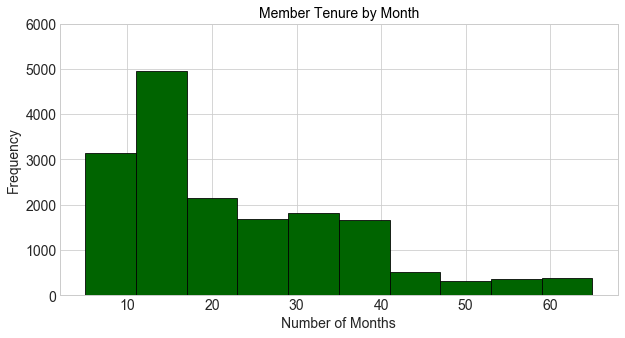

In [36]:
ax = profile['Member_Tenure'].plot.hist(figsize=(10,5), color='DarkGreen', edgecolor='k', rot=0, fontsize = 14)
_ = ax.set_title('Member Tenure by Month', fontsize = 14)
_ = ax.set_xlabel('Number of Months', fontsize = 14)
_ = ax.set_ylim([0, 6e3])

### Analyzing Transcript Data

Let's look at the Transcript data one more time.

In [37]:
transcript.head().style.hide_index()

First of all,  It can be seen that  there are $17000$ unique customer profiles in **Transcript Data**.

In [38]:
transcript['Person'].unique().shape[0]

17000

#### Event Plots

Moreover, 76277 customers received an offer, 57725 of which only viewed the received offer, and 33579 only completed the offer.

In [39]:
Summary_Transcript = transcript_portfolio.groupby(['Event'])['Event'].agg({'Count' :'count'})
Summary_Transcript

Count
Event                  
offer completed   33579
offer received    76277
offer viewed      57725
transaction      138953

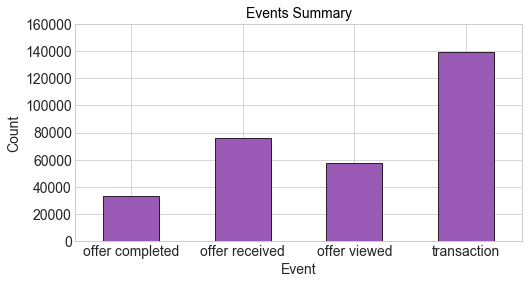

In [40]:
ax= Summary_Transcript.plot.bar(figsize=(8,4), legend = False, color='#9b59b6', edgecolor='k',fontsize = 14,rot=0)
_ = ax.set_title('Events Summary', fontsize = 14)
_ = ax.set_ylim([0, 16e4])
_ = ax.set_ylabel('Count', fontsize = 14)

We can see that only $\%44$ of customers acted on the offer that they received, and only $\%75.7$ of customers viewed the offer they received.

In [41]:
event_tp = transcript_portfolio.groupby(['Event','Offer_Type'])['Offer_Type'].agg({'Count' :'count'})
event_tp

Count
Event           Offer_Type          
offer completed bogo           15669
                discount       17910
offer received  bogo           30499
                discount       30543
                informational  15235
offer viewed    bogo           25449
                discount       21445
                informational  10831

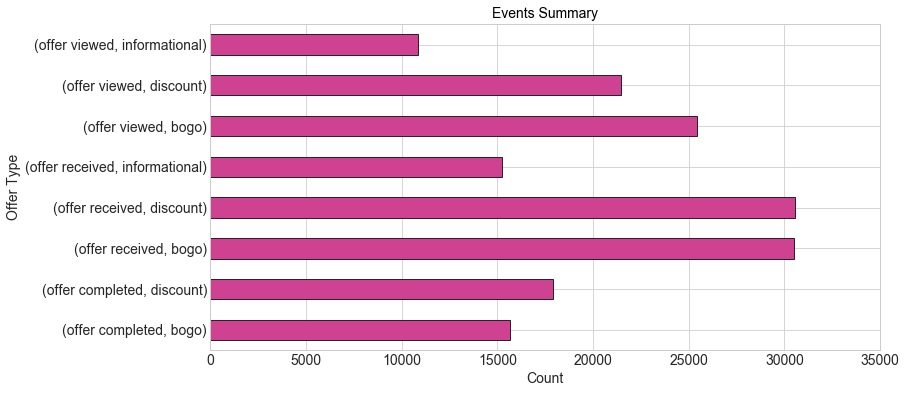

In [42]:
ax= event_tp.plot.barh(figsize=(12,6), legend = False, color= sns.color_palette("PiYG"), edgecolor='k',fontsize = 14, rot=0)
_ = ax.set_title('Events Summary', fontsize = 14)
_ = ax.set_xlim([0, 35e3])
_ = ax.set_ylabel('Offer Type', fontsize = 14)
_ = ax.set_xlabel('Count', fontsize = 14)

In [43]:
reward_received_tp = transcript_portfolio.groupby(['Reward_Received'])['Reward_Received'].agg({'Count' :'count'})
reward_received_tp

Count
Reward_Received       
2.0               9334
3.0               5156
5.0              12070
10.0              7019

#### Received Reward Plot

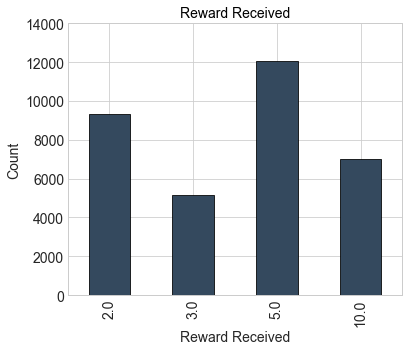

In [44]:
ax=reward_received_tp.plot.bar(figsize=(6,5), legend = False, color='#34495e', edgecolor='k',fontsize = 14)
_ = ax.set_title('Reward Received', fontsize = 14)
_ = ax.set_ylim([0, 14e3])
_ = ax.set_xlabel('Reward Received', fontsize = 14)
_ = ax.set_ylabel('Count', fontsize = 14)

#### A Customer's Journey

First off,

In [45]:
transcript_portfolio['Event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

Now, let's focus on those customers that **completed an offer**.

In [46]:
# creating a list of these customers
offer_completed_list = transcript_portfolio.loc[transcript_portfolio['Event']=='offer completed', 'Person'].tolist()

The journey of one of these customers can be analyzed  as well. For example, the first customer from the above list

In [47]:
Customer_Journey=transcript_portfolio.loc[transcript_portfolio.Person == offer_completed_list[0],:].sort_index()
Customer_Journey.head(6)

Person            Event  Time  Amount  \
36     9fa9ae8f57894cc9a3b8a9bbe0fc1b2f   offer received     0     NaN   
12656  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     offer viewed     0     NaN   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      transaction     0   34.56   
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed     0     NaN   
27850  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      transaction    42   21.55   
44327  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      transaction   114   32.87   

       Reward_Received                          Offer_ID  Reward_Defined  \
36                 NaN  2906b810c7d4411798c6938adc9daaa5             2.0   
12656              NaN  2906b810c7d4411798c6938adc9daaa5             2.0   
12657              NaN                               NaN             NaN   
12658              2.0  2906b810c7d4411798c6938adc9daaa5             2.0   
27850              NaN                               NaN             NaN   
44327              NaN                               NaN             NaN   

       Difficulty  Duration Offer_Type  Email  Mobile  Social  Web  
36           10.0       7.0   discount    1.0     1.0     0.0  1.0  
12656        10.0       7.0   discount    1.0     1.0     0.0  1.0  
12657         NaN       NaN        NaN    NaN     NaN     NaN  NaN  
12658        10.0       7.0   discount    1.0     1.0     0.0  1.0  
27850         NaN       NaN        NaN    NaN     NaN     NaN  NaN  
44327         NaN       NaN        NaN    NaN     NaN     NaN  NaN

For the modeling and further analyzing, check the next file.